**Chapter 15 – Autoencoders**

autoencoders are capable of randomly generating new data that looks very similar to the training data, this is called a generative model.

internal representation has a lower dimensionality than the input data, so that it's forced to learn the most important features.

_This notebook contains all the sample code and solutions to the exercises in chapter 15._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [10]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple utility functions to plot grayscale 28x28 image:

In [11]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [12]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [26]:
rnd = np.random

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

Normalize the data:

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

Now let's build the Autoencoder...

In [14]:
import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [13]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

Saving figure linear_autoencoder_pca_plot


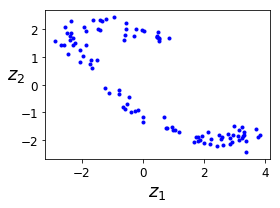

In [14]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, He initialization and L2 regularization.

In [15]:
reset_graph()

from functools import partial

# symmatrical layers
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

Now let's train it! Note that we don't feed target values (`y_batch` is not used). This is unsupervised training.

In [16]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # not shown
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown
        saver.save(sess, "./my_model_all_layers.ckpt")                  # not shown

0 Train MSE: 0.0204011
19% Train MSE: 0.0114192
2 Train MSE: 0.0102221
3 Train MSE: 0.00989991
4 Train MSE: 0.0103724


This function loads the model, evaluates it on the test set (it measures the reconstruction error), then it displays the original image and its reconstruction:

In [17]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt
Saving figure reconstruction_plot


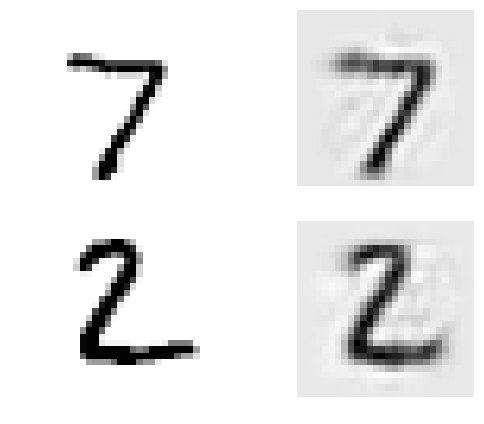

In [19]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
save_fig("reconstruction_plot")

## Tying weights

It is common to tie the weights of the encoder and the decoder (`weights_decoder = tf.transpose(weights_encoder)`). Unfortunately this makes it impossible (or very tricky) to use the `tf.layers.dense()` function, so we need to build the Autoencoder manually:

In [20]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [21]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [22]:
saver = tf.train.Saver()

In [23]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.0150667
1 Train MSE: 0.0164884
2 Train MSE: 0.0173757
3 Train MSE: 0.0168781
4 Train MSE: 0.0155875


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


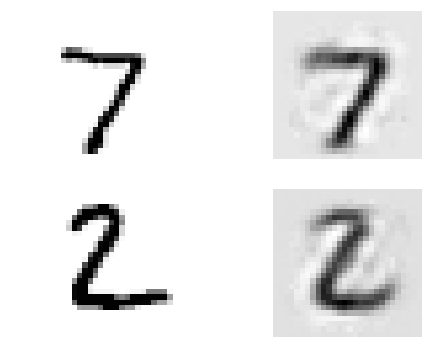

In [18]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

## Training one Autoencoder at a time in multiple graphs

There are many ways to train one Autoencoder at a time. The first approach it to train each Autoencoder using a different graph, then we create the Stacked Autoencoder by simply initializing it with the weights and biases copied from these Autoencoders.

Let's create a function that will train one autoencoder and return the transformed training set (i.e., the output of the hidden layer) and the model parameters.

In [27]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005,
                      activation=tf.nn.elu, seed=42):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            activation=activation,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=None, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

Now let's train two Autoencoders. The first one is trained on the training data, and the second is trained on the previous Autoencoder's hidden layer output:

In [28]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE: 0.0185175
1 Train MSE: 0.0186825
2 Train MSE: 0.0184675
3 Train MSE: 0.0192315
0 Train MSE: 0.00411001
1 Train MSE: 0.00461448
2 Train MSE: 0.00455272
39% Train MSE: 0.00431477


Finally, we can create a Stacked Autoencoder by simply reusing the weights and biases from the Autoencoders we just trained:

In [29]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

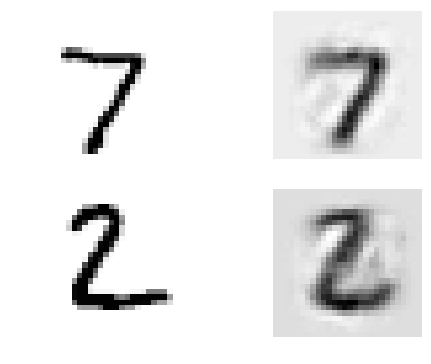

In [30]:
show_reconstructed_digits(X, outputs)

## Training one Autoencoder at a time in a single graph

Another approach is to use a single graph. To do this, we create the graph for the full Stacked Autoencoder, but then we also add operations to train each Autoencoder independently: phase 1 trains the bottom and top layer (ie. the first Autoencoder) and phase 2 trains the two middle layers (ie. the second Autoencoder).

In [31]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [32]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

In [33]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Cache the frozen layer outputs

In [35]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.00753817
1 Train MSE: 0.00775457
2 Train MSE: 0.00734359
3 Train MSE: 0.00783768
Training phase #2
0 Train MSE: 0.252959
19% Train MSE: 0.0046542
29% Train MSE: 0.00249056
39% Train MSE: 0.00205957
Test MSE: 0.0097731


## Visualizing the Reconstructions

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


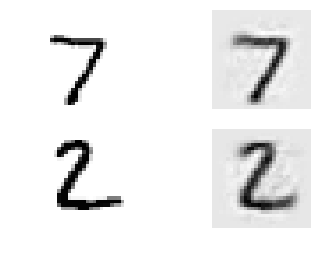

In [28]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

## Visualizing the extracted features

In [51]:
weights1_val.shape

(784, 300)

# Unsupervised pretraining

Let's create a small neural network for MNIST classification:

In [62]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

Regular training (without pretraining):

In [63]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

09% Train accuracy: 0.973333 Test accuracy: 0.9334
1 Train accuracy: 0.98 Test accuracy: 0.936
29% Train accuracy: 0.973333 Test accuracy: 0.9382
39% Train accuracy: 0.986667 Test accuracy: 0.9491


Now reusing the first two layers of the autoencoder we pretrained:

In [64]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 Train accuracy: 0.94	Test accuracy: 0.9348
1 Train accuracy: 0.993333	Test accuracy: 0.942
2 Train accuracy: 0.986667	Test accuracy: 0.9455
3 Train accuracy: 0.98	Test accuracy: 0.9487


# Stacked denoising Autoencoder

Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. This prevents the autoencoder from trivially copying its inputs to its outputs.

The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched off inputs, just like in dropout

Note: the book uses `tf.contrib.layers.dropout()` rather than `tf.layers.dropout()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dropout()`, because anything in the contrib module may change or be deleted without notice. The `tf.layers.dropout()` function is almost identical to the `tf.contrib.layers.dropout()` function, except for a few minor differences. Most importantly:
* you must specify the dropout rate (`rate`) rather than the keep probability (`keep_prob`), where `rate` is simply equal to `1 - keep_prob`,
* the `is_training` parameter is renamed to `training`.

Using Gaussian noise:

In [65]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [69]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
# add Gaussian noise
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [67]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [36]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.0440489
1 Train MSE: 0.0432517
2 Train MSE: 0.042057
3 Train MSE: 0.0409477
4 Train MSE: 0.0402107
5 Train MSE: 0.0388787
6 Train MSE: 0.0391096
7 Train MSE: 0.0421885
8 Train MSE: 0.0398648
9 Train MSE: 0.0408181


Using dropout:

In [70]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [71]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [72]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [73]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.0302958
1 Train MSE: 0.0292939
2 Train MSE: 0.027049
3 Train MSE: 0.0253021
49% Train MSE: 0.0243453
5 Train MSE: 0.0247929
6 Train MSE: 0.0237942
7 Train MSE: 0.0252127
8 Train MSE: 0.0237634
9 Train MSE: 0.0247091


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


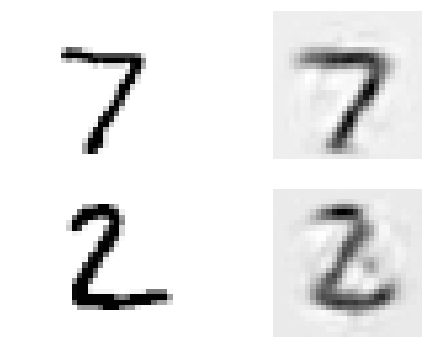

In [74]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

# Sparse Autoencoder

Saving figure sparsity_loss_plot


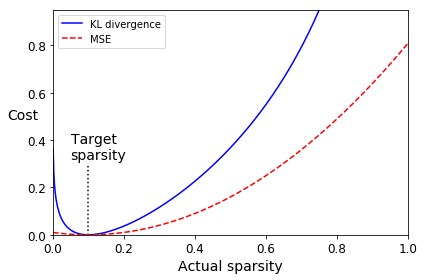

In [80]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [107]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [108]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

# Note that the coding layer must output values from 0 to 1, which is why we use the sigmoid activation function:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # not shown
#outputs = tf.layers.dense(hidden1, n_outputs)                     # not shown
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=outputs)
reconstruction_loss = tf.reduce_mean(xentropy)

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
#reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [109]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [112]:
n_epochs = 40
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train loss:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train loss: 0.715603 	Sparsity loss: 0.333232 	Total loss: 0.78225
1 Train loss: 0.708853 	Sparsity loss: 0.0746283 	Total loss: 0.723779
2 Train loss: 0.703599 	Sparsity loss: 0.0109317 	Total loss: 0.705785
3 Train loss: 0.698804 	Sparsity loss: 0.627469 	Total loss: 0.824298
4 Train loss: 0.696388 	Sparsity loss: 0.0724939 	Total loss: 0.710886
5 Train loss: 0.695163 	Sparsity loss: 0.0227809 	Total loss: 0.69972
6 Train loss: 0.692975 	Sparsity loss: 0.00796508 	Total loss: 0.694568
7 Train loss: 0.691804 	Sparsity loss: 0.0855785 	Total loss: 0.708919
8 Train loss: 0.690664 	Sparsity loss: 0.0993482 	Total loss: 0.710533
9 Train loss: 0.689972 	Sparsity loss: 0.192672 	Total loss: 0.728506
10 Train loss: 0.689334 	Sparsity loss: 0.172671 	Total loss: 0.723869
11 Train loss: 0.688208 	Sparsity loss: 0.0431758 	Total loss: 0.696843
12 Train loss: 0.687773 	Sparsity loss: 0.0242359 	Total loss: 0.69262
13 Train loss: 0.686685 	Sparsity loss: 0.28806 	Total loss: 0.744297
14 Train l

In [ ]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

To speed up training, you can normalize the inputs between 0 and 1, and use the cross entropy instead of the MSE for the cost function:

In [89]:
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)

# Variational Autoencoder

In [114]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)


xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [122]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 18001.2 	Reconstruction loss: 14354.6 	Latent loss: 3646.63
1 Train total loss: 17302.7 	Reconstruction loss: 13486.1 	Latent loss: 3816.68
2 Train total loss: 16325.4 	Reconstruction loss: 12567.7 	Latent loss: 3757.69
3 Train total loss: 16941.6 	Reconstruction loss: 13052.6 	Latent loss: 3889.02
4 Train total loss: 16673.8 	Reconstruction loss: 12839.9 	Latent loss: 3833.88
5 Train total loss: 16383.3 	Reconstruction loss: 12508.7 	Latent loss: 3874.66
6 Train total loss: 15648.4 	Reconstruction loss: 11832.8 	Latent loss: 3815.56
7 %Train total loss: 15907.0 	Reconstruction loss: 12143.8 	Latent loss: 3763.18
8 Train total loss: 15872.5 	Reconstruction loss: 12038.6 	Latent loss: 3833.9
9 %Train total loss: 15420.3 	Reconstruction loss: 11644.6 	Latent loss: 3775.71
10 Train total loss: 15999.1 	Reconstruction loss: 12129.5 	Latent loss: 3869.58
11 Train total loss: 16154.9 	Reconstruction loss: 12284.2 	Latent loss: 3870.7
12 Train total loss: 15481.6 	Reconstr

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


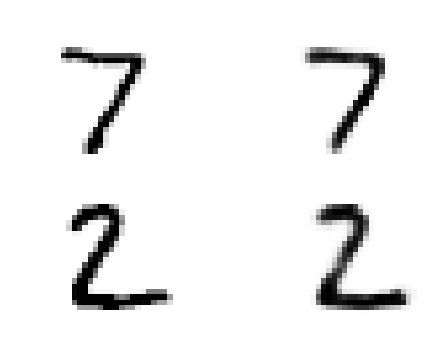

In [123]:
show_reconstructed_digits(X, outputs, "./my_model_variational.ckpt")

## Generate digits

Let's train the model and generate a few random digits:

In [125]:
import numpy as np

n_digits = 60    # try 60 digits
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


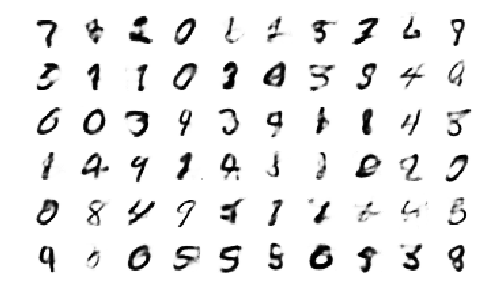

In [126]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

Saving figure generated_digits_plot


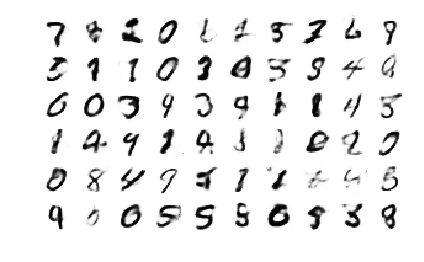

In [127]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
save_fig("generated_digits_plot")
plt.show()

## Encode & Decode

Encode:

In [137]:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    # encode from X
    codings_val = codings.eval(feed_dict={X: X_test})
    # decode
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


Let's plot the reconstructions:

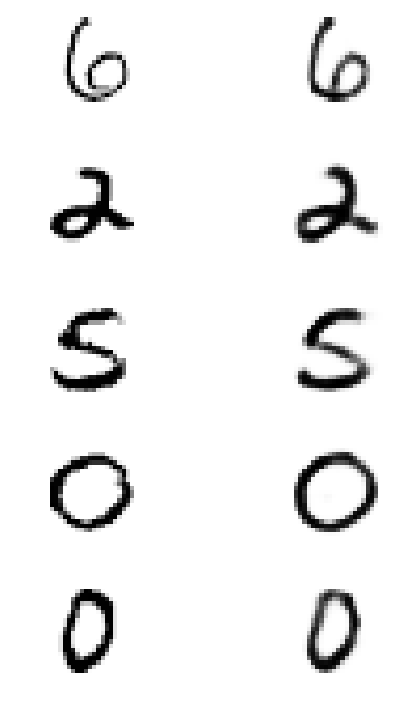

In [138]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

## Interpolate digits

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


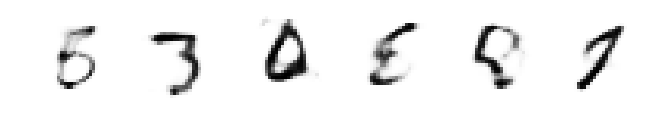

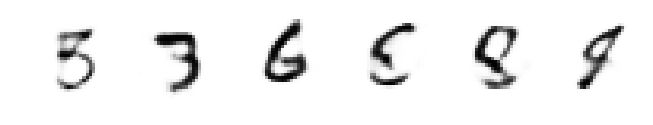

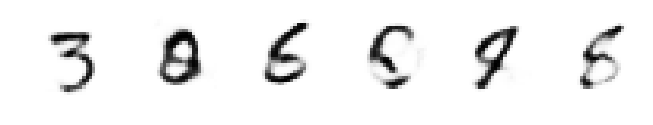

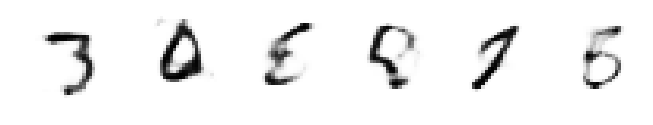

In [133]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()

# Exercise solutions

Coming soon...